In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [12]:
notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")

C:\Users\jguo27\AppData\Local\Temp\ipykernel_14984\344147374.py:1: DtypeWarning: Columns (0: believable, 1: harmful, 2: validationDifficulty) have mixed types. Specify dtype option on import or set low_memory=False.
  notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")


In [13]:
notes_raw.columns

Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'isCollaborativeNote'],
      dtype='str')

In [14]:
notes_raw = notes_raw[["noteId", "tweetId", "classification"]]

In [15]:
notes_topic = pd.read_parquet("./outputs/notes_with_topics.parquet", engine="pyarrow")

In [16]:
notes_topic = notes_topic[["noteId", "summary_en", "lang", "topic"]]

In [17]:
notes = notes_topic.merge(
    notes_raw[["noteId", "tweetId", "classification"]],
    on="noteId",
    how="left"
)

In [18]:
print(notes.columns.tolist())


['noteId', 'summary_en', 'lang', 'topic', 'tweetId', 'classification']


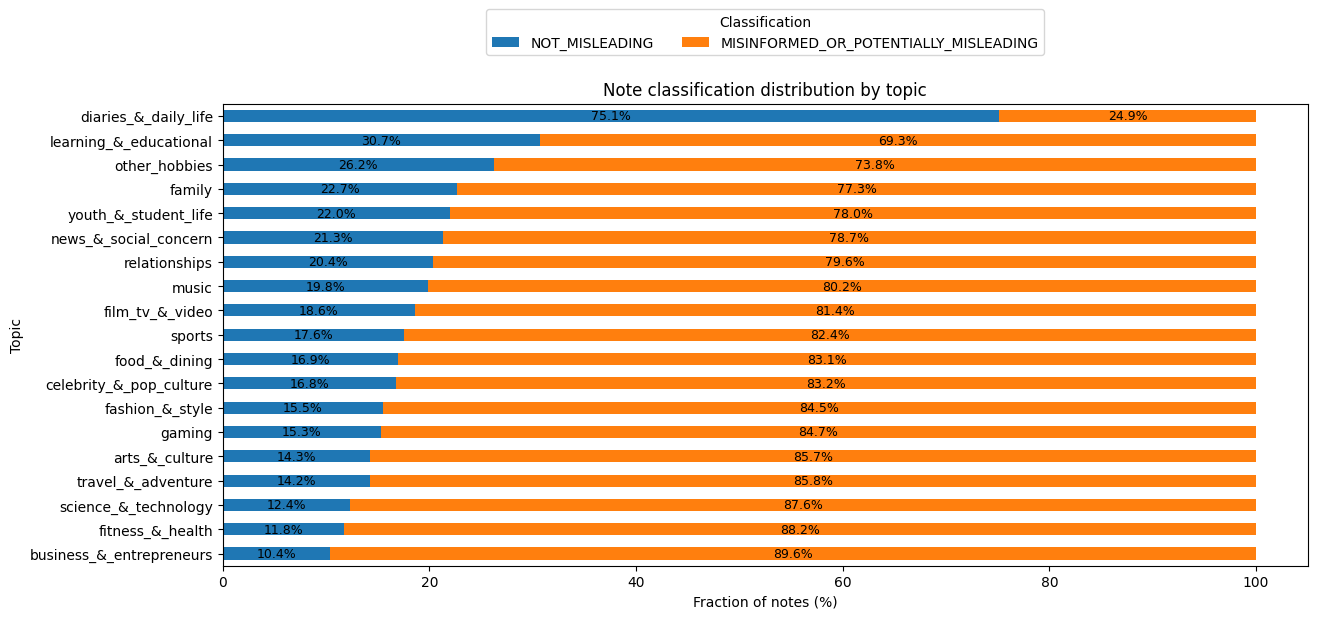

In [23]:
import matplotlib.pyplot as plt

plot_df = notes.dropna(subset=["topic", "classification"]).copy()

# counts: topic × classification
dist = (
    plot_df.groupby(["topic", "classification"])
           .size()
           .unstack(fill_value=0)
)

# convert to percent within each topic
pct = dist.div(dist.sum(axis=1), axis=0) * 100

# sort topics by MISINFORMED
mis = "MISINFORMED_OR_POTENTIALLY_MISLEADING"
if mis in pct.columns:
    pct = pct.sort_values(mis, ascending=False)

# set column order
col_order = ["NOT_MISLEADING", "MISINFORMED_OR_POTENTIALLY_MISLEADING"]
pct = pct.reindex(columns=[c for c in col_order if c in pct.columns], fill_value=0)

ax = pct.plot(kind="barh", stacked=True, figsize=(14, 6))
ax.set_xlabel("Fraction of notes (%)")
ax.set_ylabel("Topic")
ax.set_title("Note classification distribution by topic")
plt.legend(
    title="Classification",
    bbox_to_anchor=(0.5, 1.22), 
    loc="upper center",
    ncol=2
)


# label percentages in the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=9)

plt.show()


In [24]:
ratings = pd.read_csv("../data/ratings-00000.tsv", sep="\t")

In [25]:
ratings.head()

,noteId,raterParticipantId,createdAtMillis,version,agree,disagree,helpful,notHelpful,helpfulnessLevel,helpfulOther,...,notHelpfulOutdated,notHelpfulHardToUnderstand,notHelpfulArgumentativeOrBiased,notHelpfulOffTopic,notHelpfulSpamHarassmentOrAbuse,notHelpfulIrrelevantSources,notHelpfulOpinionSpeculation,notHelpfulNoteNotNeeded,ratedOnTweetId,ratingSourceBucketed
0,1623847761874501633,10E815A3D3774CA091E6FD4D15172E60EBE0130B8F6848...,1676004604386,2,0,0,0,0,NOT_HELPFUL,0,...,0,0,0,0,0,0,0,0,-1,DEFAULT
1,1646969426284105747,10E815A3D3774CA091E6FD4D15172E60EBE0130B8F6848...,1681583068355,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,1646640890092351488,DEFAULT
2,1849246700252401952,10E815A3D3774CA091E6FD4D15172E60EBE0130B8F6848...,1729735019612,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,1849217132183060705,DEFAULT
3,1875194033124807036,10E815A3D3774CA091E6FD4D15172E60EBE0130B8F6848...,1735917430088,2,0,0,0,0,NOT_HELPFUL,0,...,0,0,0,0,0,0,0,0,1874917061820039254,DEFAULT
4,1644423392089481220,14B38D5E8C8FA9736488E6FBBFCE130FFC7525BE49CEFB...,1680975159184,2,0,0,0,0,NOT_HELPFUL,0,...,0,0,0,0,0,0,0,0,1644409243989155841,DEFAULT


In [27]:
import pandas as pd
from glob import glob

RATINGS_GLOB = "../data/ratings-*.tsv"
paths = sorted(glob(RATINGS_GLOB))
print("rating files:", len(paths))

levels = ["HELPFUL", "NOT_HELPFUL", "SOMEWHAT_HELPFUL"]

# 用一个总表累计（index=noteId）
total = None

for p in paths:
    r = pd.read_csv(
        p,
        sep="\t",
        usecols=["noteId", "helpfulnessLevel"],
        dtype={"noteId": "string", "helpfulnessLevel": "category"},  # 省内存
        low_memory=False,
    ).dropna(subset=["noteId", "helpfulnessLevel"])

    # 每个文件先聚合成 noteId × level 的计数
    g = (
        r.groupby(["noteId", "helpfulnessLevel"])
         .size()
         .unstack(fill_value=0)
    )

    # 补齐三列，避免有的文件缺某个 level
    for c in levels:
        if c not in g.columns:
            g[c] = 0
    g = g[levels]

    # 累加到总表
    if total is None:
        total = g
    else:
        total = total.add(g, fill_value=0)

# 收尾：转回 DataFrame
note_votes = total.reset_index()
note_votes[levels] = note_votes[levels].astype("int32")

note_votes["note_status"] = note_votes[levels].idxmax(axis=1)

note_votes[["noteId", "note_status"]].head()


rating files: 20


helpfulnessLevel,noteId,note_status
0,1354586938863443971,SOMEWHAT_HELPFUL
1,1354600130578624514,NOT_HELPFUL
2,1354640847245955073,NOT_HELPFUL
3,1354678831655735296,HELPFUL
4,1354815735491518467,NOT_HELPFUL


In [29]:
notes["noteId"] = notes["noteId"].astype("string")
note_votes["noteId"] = note_votes["noteId"].astype("string")

notes2 = notes.merge(
    note_votes[["noteId", "note_status"]],
    on="noteId",
    how="left"
)

# get rid of notes without rating
notes2 = notes2.dropna(subset=["note_status"])


In [30]:
prio = {"NOT_HELPFUL": 1, "SOMEWHAT_HELPFUL": 2, "HELPFUL": 3}

notes2["p"] = notes2["note_status"].map(prio).astype("int8")

post_best = (
    notes2.dropna(subset=["topic", "tweetId"])
          .groupby("tweetId", as_index=False)
          .agg(
              topic=("topic", "first"),
              p=("p", "max"),
          )
)

inv = {v: k for k, v in prio.items()}
post_best["post_status"] = post_best["p"].map(inv)


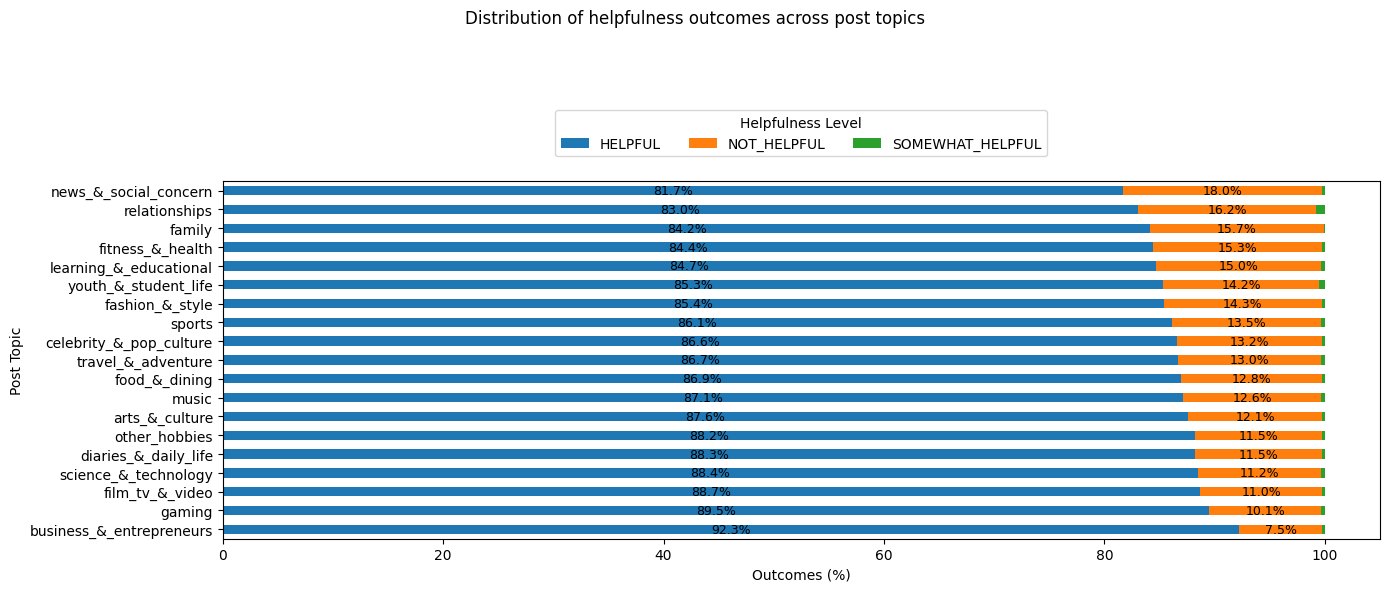

In [ ]:
import matplotlib.pyplot as plt

dist = (
    post_best.groupby(["topic", "post_status"])
             .size()
             .unstack(fill_value=0)
)

pct = dist.div(dist.sum(axis=1), axis=0) * 100

# helpful sort
if "HELPFUL" in pct.columns:
    pct = pct.sort_values("HELPFUL", ascending=False)

# fix order
col_order = ["HELPFUL", "NOT_HELPFUL", "SOMEWHAT_HELPFUL"]
pct = pct.reindex(columns=col_order, fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
pct.plot(kind="barh", stacked=True, ax=ax)

ax.set_xlabel("Outcomes (%)")
ax.set_ylabel("Post Topic")
fig.suptitle("Distribution of helpfulness outcomes across post topics", y=0.98)

ax.legend(
    title="Helpfulness Level",
    bbox_to_anchor=(0.5, 1.05),
    loc="lower center",
    ncol=3
)

for container in ax.containers:
    labels = [f"{v:.1f}%" if v >= 3 else "" for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()
